In [1]:
##################################################
##本代码实现并训练了一个解决MNIST手写数字识别的SOM模型
##语言：Python3
##################################################

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

In [3]:
data = np.loadtxt("./SOM_MNIST_data.txt").transpose()
#data.shape
#导入数据
#文件中有5000条数据，每个数据有784个特征

In [4]:
def normal_X(X):
    #数据归一化处理
    N, D = X.shape
    for i in range(N):
        temp = np.sum(np.multiply(X[i], X[i]))
        X[i] /= np.sqrt(temp)
    return X

In [5]:
def normal_W(W):
    #权重归一化处理
    for i in range(W.shape[1]):
        temp = np.sum(np.multiply(W[:,i], W[:,i]))
        W[:, i] /= np.sqrt(temp)
    return W

In [6]:
class SOM(object):
    def __init__(self, X, output, iteration, batch_size):
        self.X = X
        self.output = output
        self.iteration = iteration
        self.batch_size = batch_size
        self.W = np.random.rand(X.shape[1], output[0] * output[1])
        np.savetxt('initial.txt',self.W.transpose())
    
    def getneighbor(self, index, N):
        #获得获胜神经元的拓扑领域
        a, b = self.output
        length = a*b
        def distence(index1, index2):
            i1_a, i1_b = index1 // a, index1 % b
            i2_a, i2_b = index2 // a, index2 % b
            return np.abs(i1_a - i2_a), np.abs(i1_b - i2_b)
        ans = [set() for i in range(N+1)]
        for i in range(length):
            dist_a, dist_b = distence(i, index)
            if dist_a <= N and dist_b <= N: 
                ans[max(dist_a, dist_b)].add(i)
        return ans

    def GetN(self, t):
        a = min(self.output)
        return int(a - float(a) * t/self.iteration)
    
    def Geteta(self, t, n):
        #依赖于迭代次数的学习率
        return np.power(np.e, -n) / (t + 2)
    
    def updata_W(self, X, t, winner):
        #更新权重，包括获胜神经元的权重以及获胜神经元所处拓扑领域的权重
        N = self.GetN(t)
        for x, i in enumerate(winner):
            to_update = self.getneighbor(i, N)
            for j in range(N+1):
                e = self.Geteta(t, j)
                for w in to_update[j]:
                    self.W[:, w] = np.add(self.W[:,w], e*(X[x,:] - self.W[:,w]))


    def train(self):
        #训练过程
        count = 0
        list_mse= []
        while self.iteration > count:
            train_X = self.X[np.random.choice(self.X.shape[0], self.batch_size)]
            normal_W(self.W)
            normal_X(train_X)
            train_Y = train_X.dot(self.W)
            winner = np.argmax(train_Y, axis=1).tolist()
            #print(winner)
            self.updata_W(train_X, count, winner)
            count += 1
            #print(np.max(train_Y, axis=1))
            mse = np.min(train_Y,axis=1).sum()/200
            #print(mse)
            list_mse.append(mse)
            #if count == self.iteration/2:
                #np.savetxt('middle.txt',self.W.transpose())
        return self.W,list_mse 
    
    #下面的内容是聚类函数的实现，根据训练出来的权重，将数据集进行聚类，聚类函数输出测试数据在竞争层中的坐标
    def cluster(self, X):
        X = normal_X(X)
        m = X.shape[0]
        cluster_labels = []
        for i in range(m):
            dis = X[i].dot(normal_W(self.W))
            re_dis = dis.reshape(self.output[0],self.output[1])
            l = np.where(re_dis == np.max(re_dis))
            cluster_labels.append(l)
        return np.array(cluster_labels)

In [7]:
##实例化，输入数据集，定义SOM的竞争层的结构是10*10，并且定义迭代次数和batch数量
som = SOM(data,(10,10),1000,1000)

w,mse = som.train()

np.savetxt('final.txt',normal_W(w).transpose())

np.savetxt('train.txt',mse)

In [8]:
##下面的内容是绘制SOM竞争层拓扑结构，initial.txt中存储的是初始状态，final.txt中存储的是经过训练后的状态
from PIL import Image
 
converge = np.loadtxt('final.txt')
initial = np.loadtxt('initial.txt')

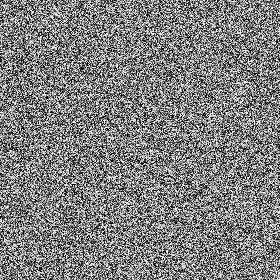

In [9]:
#绘制初始状态，可以看出，开始时的竞争层是随机的，无结构的
picture_initial = np.zeros((280,280))
for i in range(10):
    for j in range(10):
        picture_initial[28*i:28*(i+1),28*j:28*(j+1)] = initial[i*10+j].reshape(28,28).transpose()

pic_initial = np.expand_dims(np.uint8(picture_initial * 255/np.max(picture_initial)),2).repeat(3,axis=2)
Image.fromarray(pic_initial)

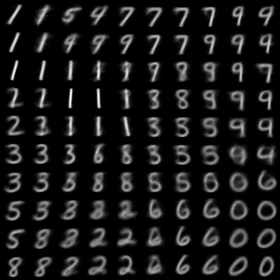

In [10]:
##注：需要注意的是，由于初始的权重值是随机的，所以每次运行时，最终的结构不尽相同。
#绘制最终状态，可以看出此时的竞争层已经有了相对完整、清晰的拓扑结构，
#但是同样可以看出，该算法的表现并不完美，图中有一部分”4“与”9“没有区分开
picture_converge = np.zeros((280,280))
for i in range(10):
    for j in range(10):
        picture_converge[28*i:28*(i+1),28*j:28*(j+1)] = converge[i*10+j].reshape(28,28).transpose()

pic_final = np.expand_dims(np.uint8(picture_converge * 255/np.max(picture_converge)),2).repeat(3,axis=2)
Image.fromarray(pic_final)

In [11]:
##对SOM进行测试
#为了可视化，这里选择抽取一条mnist中的数据进行测试并将其可视化。如果需要，比如说批量识别手写数字，也可以输入整个数据集
#首先，随机从mnist数据集中抽取一条数据
Xhat = data[169:170,:]

#将这条数据可视化，可以看出这是一个手写的“4”
re_Xhat = Xhat.reshape(28,28).transpose()
pic_Xhat = np.expand_dims(np.uint8(re_Xhat * 255/np.max(re_Xhat)),2).repeat(3,axis=2)
Image.fromarray(pic_Xhat)

In [12]:
#利用聚类函数测试SOM
X_topology = som.cluster(Xhat)
#输出这条测试数据在SOM拓扑结构中的坐标
print(X_topology)

[[[0]
  [9]]]


In [13]:
#可以看出，这条数据落在了SOM拓扑结构的第3+1=4行，第6+1=7列，通过上面对SOM整体结构的可视化可以看出，第4行第7列是”4“

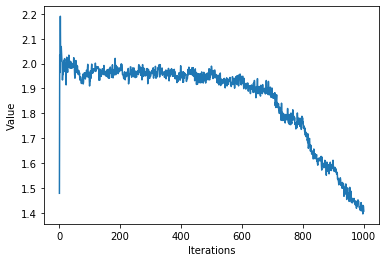

In [14]:
##模型效果分析
#可视化模型多次迭代的mse
import csv
fileName = './train.txt'
with open(fileName) as f:
    reader = csv.reader(f)
    index, mse = [], []
    for ind, row in enumerate(reader):
        index.append(ind+1)
        mse.append(float(row[0]))
    #print(index)
    #print(mse)
    plt.plot(index,mse)
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.show()